In [ ]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import get_data_params, get_net_params 
from datasets import load_dataset

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 14})
plt.show()

np.set_printoptions(suppress=True)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

# Load in datasets

In [ ]:
data_params = get_data_params("mnist_basic")

x_train, y_train, x_val, y_val, x_test, y_test = load_dataset("california_housing", data_params, verbose=True)

In [ ]:
print("="*50)
print("  Running Unit Tests for the load_dataset Function  ")
print("="*50)

# List of datasets the function is supposed to handle, plus an invalid one
datasets_to_test = ["mnist", "cifar10", "imdb", "california_housing", "unknown_dataset"]
failed_tests = []
successful_tests = []

for name in datasets_to_test:
    print(f"\n>>> Testing dataset: '{name}'...")
    try:
        # Call the function and suppress its verbose output for cleaner test logs
        x_train, y_train, x_val, y_val, x_test, y_test = load_dataset(
            dataset_name=name, 
            params=None, 
            verbose=True
        )

        # Add a check to ensure the validation split isn't empty, a common slicing error
        if x_val.shape[0] == 0:
            raise ValueError("Validation split resulted in an empty array. Check slicing logic.")

        print(f"[SUCCESS] '{name}' loaded and passed all assertions.")
        successful_tests.append(name)

    except Exception as e:
        print(f"[ERROR]: '{name}' encountered an error.")
        print(f"   Error Type:    {type(e).__name__}")
        print(f"   Error Details: {e}")
        failed_tests.append(name)

# --- Final Summary ---
print("\n" + "="*50)
print("                  TEST SUMMARY")
print("="*50)
print(f"Successful tests ({len(successful_tests)}): {', '.join(successful_tests) if successful_tests else 'None'}")
print(f"Failed tests ({len(failed_tests)}): {', '.join(failed_tests) if failed_tests else 'None'}")
print("="*50)

if failed_tests:
    print("\nReview the 'ERROR' sections above to debug your function.")

# Build network

In [ ]:
net_name = "base_cnn"
net_params = get_net_params(net_name)

inputs = tf.keras.Input(shape=net_params["input_shape"])
x = inputs

for layer in net_params["conv_layers"]:
    x = tf.keras.layers.Conv2D(
        filters=layer["filters"],
        kernel_size=layer["kernel_size"],
        activation=None,
        padding="same"
    )(x)
    if layer.get("batch_norm", False):
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(layer["activation"])(x)
    if layer.get("max_pool", False):
        x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x)

# Dense Layers
for layer in net_params["dense_layers"]:
    x = tf.keras.layers.Dense(layer["units"], activation=layer["activation"])(x)
    if "dropout_rate" in layer:
        x = tf.keras.layers.Dropout(layer["dropout_rate"])(x)

# Output Layer
outputs = tf.keras.layers.Dense(net_params["num_classes"], activation=net_params["output_layer"]["activation"])(x)

model = tf.keras.Model(inputs, outputs, name=net_name)


In [ ]:
opt_config = net_params["optimizer"]
optimizer = getattr(tf.optimizers, opt_config["type"].capitalize())(learning_rate=opt_config["learning_rate"])

model.compile(
    optimizer=optimizer,
    loss=net_params["loss"],
    metrics=net_params["metrics"]
)

model.summary()

st = time.time()
# Train
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val) if x_val is not None else None,
    epochs=net_params["epochs"],
    batch_size=net_params["batch_size"],
    shuffle=data_params.get("shuffle", True)
)
training_duration_seconds = time.time() - st

In [ ]:
from utils import analyze_history

analyze_history(history)

In [ ]:
from utils import save_model_wts

save_model_wts(model=model, data_name="mnist", history= history, training_duration_seconds=training_duration_seconds)

In [ ]:
from utils import load_json_results

results = load_json_results(name="base_cnn_mnist_2025-08-07_11-50", print_results=True)

# CNN Class tests

In [1]:
import tensorflow as tf

from base_networks import CNN, MLP
from datasets import load_dataset
from utils import get_net_params, get_data_params, analyze_history, load_json_results

2025-08-07 16:37:39.944188: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 16:37:39.959179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754599059.973298  119990 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754599059.977362  119990 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754599059.988324  119990 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
base_cnn_params = get_net_params("base_cnn")
# reg_cnn_params = get_net_params("base_mlp")
data_params = get_data_params("cifar10_basic")
# reg_data_params = get_data_params("california_housing_basic")

cifar_data = load_dataset("cifar10", data_params, verbose=True)
# california_data = load_dataset("california_housing", reg_data_params, verbose=True)

# --- Build the SINGLE-OUTPUT Classification Model ---
print("\n---- BUILDING CLASSIFICATION MODEL ----")
mnist_model_wrapper = CNN(params=base_cnn_params)
mnist_model = mnist_model_wrapper.build_model(data_params=data_params, print_summary=False)
mnist_model_wrapper.compile_model()

history = mnist_model_wrapper.fit_model(x_train=cifar_data[0], y_train=cifar_data[1], 
                                        x_val=cifar_data[2], y_val=cifar_data[3], 
                                        save_wts=True, verbose=True)
# --- Build the MULTI-OUTPUT Regression Model ---
# print("\n\n---- BUILDING REGRESSION MODEL ----")
# property_model_wrapper = MLP(net_params=reg_cnn_params)
# property_model = property_model_wrapper.build_model(data_params=reg_data_params, print_summary=True)
# property_model_wrapper.compile_model()

[NOTICE] Using CIFAR-10 dataset from TensorFlow Datasets, params file will be ignored.

             DATASET SHAPES             
Training Data (x):       (40000, 32, 32, 3)
Training Labels (y):     (40000, 1)
----------------------------------------
Validation Data (x):     (10000, 32, 32, 3)
Validation Labels (y):   (10000, 1)
----------------------------------------
Test Data (x):           (10000, 32, 32, 3)
Test Labels (y):         (10000, 1)


---- BUILDING CLASSIFICATION MODEL ----
Initialized model 'base_cnn'.
Building single-output classification head...
Model compiled successfully.


2025-08-07 16:37:43.919039: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,409,418 (32.08 MB)

 Trainable params: 8,409,418 (32.08 MB)

 Non-trainable params: 0 (0.00 B)

Configured early_stopping with params: {'monitor': 'val_loss', 'patience': 10, 'restore_best_weights': True}
Configured model_checkpoint with params: {'filepath': 'checkpoints/model_{epoch:02d}.weights.h5', 'monitor': 'val_loss', 'save_best_only': True, 'save_weights_only': True}
Configured reduce_lr_on_plateau with params: {'monitor': 'val_loss', 'factor': 0.1, 'patience': 5, 'min_lr': 1e-05}
Epoch 1/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.2583 - loss: 28.1656 - val_accuracy: 0.3812 - val_loss: 1.7150 - learning_rate: 0.0010
Epoch 2/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.4074 - loss: 1.6430 - val_accuracy: 0.4349 - val_loss: 1.5588 - learning_rate: 0.0010
Epoch 3/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.4772 - loss: 1.4535 - val_accuracy: 0.4701 - val_loss: 1.4980 - learning_rate: 0.0010
Epoch 4/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.5358 - loss: 1.2950 - val_accuracy: 0.4785 - val_loss: 1.4868 - 

                       MODEL HISTORY                        
Ran for 14 epochs out of a max of 500 epochs.
History tracking: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']

Metric: Accuracy
  - Best Train:   0.8708 at epoch 14
  - Best Val: 0.5142 at epoch 12
Metric: Loss
  - Best Train:   0.3631 at epoch 14
  - Best Val: 1.4868 at epoch 4
Metric: Learning Rate
  - Best Train:   0.0001 at epoch 10



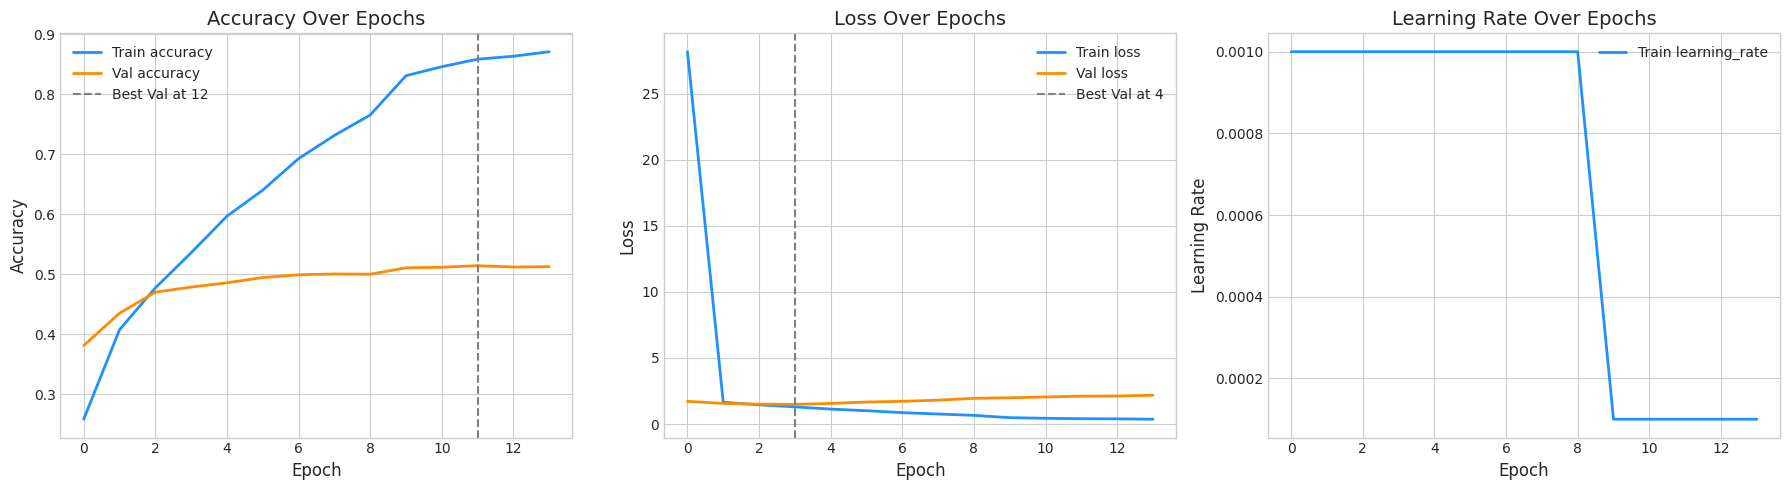


             Info for functional-cifar10_2025-08-07_16-47             
Top-level keys: 5                                
----------------------------------------------------------------------
  ├─ dataset: 'cifar10'
  ├─ epochs_trained: 14
  ├─ training_duration_seconds: 560.63
  ├─ final_loss: 0.3630622625350952
  ├─ history (dict):
    ├─ accuracy (list, 14 items of type float):
    ├─ loss (list, 14 items of type float):
    ├─ val_accuracy (list, 14 items of type float):
    ├─ val_loss (list, 14 items of type float):
    ├─ learning_rate (list, 14 items of type float):



In [3]:
analyze_history(history)
results = load_json_results(name="functional-cifar10_2025-08-07_16-47", print_results=True)